# <u><center>Project 2 Part 6 Core
- Authored by: Eric N. Valdez
- Date: 4/12/2024

## <u>Instructions
For this part of the project, you will be using machine learning and deep NLP to classify the reviews.

# Imports:

In [3]:
import joblib
%load_ext autoreload
%autoreload 2
import movie_functions as fn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%reload_ext autoreload

# Load and Clean Data
- Use the original review column as your X and the classification target (High/Low Rating Reviews) as your y:

In [5]:
# loading the joblib from part 5 of the project
df = joblib.load('Data-NLP/processed_data.joblib')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8650 entries, 843 to 575264
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   original_title  8650 non-null   object 
 1   review          8650 non-null   object 
 2   rating          7454 non-null   float64
 3   ratings         2419 non-null   object 
 4   tokens          8650 non-null   object 
 5   lemmatized      8650 non-null   object 
 6   tokens-joined   8650 non-null   object 
 7   lemmas-joined   8650 non-null   object 
dtypes: float64(1), object(7)
memory usage: 608.2+ KB


,original_title,review,rating,ratings,tokens,lemmatized,tokens-joined,lemmas-joined
movie_id,,,,,,,,
843,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife, the other a business executive and his wife. The ...",7.0,None,"[fine, piece, cinema, wong, kar, wai, tell, story, people, circumstance, throw, way, expect, start, couple, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leave, increasingly, loose, end, long, friendship, develop, usually, noodle, en...","[fine, piece, cinema, wong, kar, wai, tell, story, people, circumstance, throw, way, expect, start, couple, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leave, increasingly, loose, end, long, friendship, develop, usually, noodle, en...",fine piece cinema wong kar wai tell story people circumstance throw way expect start couple new building newspaper man wife business executive wife businessman rarely home journalist wife leave increasingly loose end long friendship develop usually noodle entirely platonic relationship solid tru...,fine piece cinema wong kar wai tell story people circumstance throw way expect start couple new building newspaper man wife business executive wife businessman rarely home journalist wife leave increasingly loose end long friendship develop usually noodle entirely platonic relationship solid tru...
7443,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0,High_rating,"[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]","[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]",guilty pleasure personally love great escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation,guilty pleasure personally love great escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation
7443,Chicken Run,"Made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. It's maybe not as great as I remember thinking it was when I was a little kid, but it still holds up to some degree.\r\n\r\n_Final rating:★★★ - I liked it. Would personally recommend you give it a ...",6.0,None,"[roommate, hate, stop, motion, animation, watch, 2018, good, time, maybe, great, remember, think, little, kid, hold, degree, final, rating, ★, ★, ★, like, personally, recommend]","[roommate, hate, stop, motion, animation, watch, 2018, good, time, maybe, great, remember, think, little, kid, hold, degree, final, rating, ★, ★, ★, like, personally, recommend]",roommate hate stop motion animation watch 2018 good time maybe great remember think little kid hold degree final rating ★ ★ ★ like personally recommend,roommate hate stop motion animation watch 2018 good time maybe great remember think little kid hold degree final rating ★ ★ ★ like personally recommend
7443,Chicken Run,"A very good stop-motion animation!\r\n\r\n<em>'Chicken Run'</em>, which I watched a crap tonne when I was little but not for a vast number of years now, is an impressive production given it came out in 2000. Despite a pretty simple feel to the film, it's a very well developed concept.\r\n\r\nThe...",8.0,None,"[good, stop, motion, animation, <, em>'chicken, run'</em, >, watch, crap, tonne, little, vast, number, year, impressive, producti

In [6]:
def create_groups(x):
    if x>=5.0:
        return "None"
    elif x <=9.0:
        return "None"
    elif x >=9.0: 
        return "High"
    elif x<=4.0:
        return "Low"

In [7]:
# Use the function to create a new "rating" column with groups
df['no_rating'] = df['rating'].map(create_groups)
df['no_rating'].value_counts(dropna=False)

None    7454
None    1196
Name: no_rating, dtype: int64

In [8]:
## Check class balance of 'rating'
df['ratings'].value_counts(normalize=True)

Low_rating     0.505994
High_rating    0.494006
Name: ratings, dtype: float64

In [9]:
# Create a df_ml without null ratings
df = df.dropna(subset=['ratings']).copy()
df.isna().sum()

original_title    0
review            0
rating            0
ratings           0
tokens            0
lemmatized        0
tokens-joined     0
lemmas-joined     0
no_rating         0
dtype: int64

In [10]:
df.head()

,original_title,review,rating,ratings,tokens,lemmatized,tokens-joined,lemmas-joined,no_rating
movie_id,,,,,,,,,
7443,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0,High_rating,"[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]","[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]",guilty pleasure personally love great escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation,guilty pleasure personally love great escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation,None
955,Mission: Impossible II,"The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully underdeveloped).\r\n\r\nEven setting it in predom...",3.0,Low_rating,"[underwhelme, straight, bore, course, see, hunt, climb, mountain, harness, impressive, sure, like, idea, villain, piece, angle, woefully, underdeveloped, set, predominantly, australia, grab, attention, say, cause, pretty, biased, come, hear, tell, mission, impossible, ii, low, point, series, enc...","[underwhelme, straight, bore, course, see, hunt, climb, mountain, harness, impressive, sure, like, idea, villain, piece, angle, woefully, underdeveloped, set, predominantly, australia, grab, attention, say, cause, pretty, biased, come, hear, tell, mission, impossible, ii, low, point, series, enc...",underwhelme straight bore course see hunt climb mountain harness impressive sure like idea villain piece angle woefully underdeveloped set predominantly australia grab attention say cause pretty biased come hear tell mission impossible ii low point series encouraging bad know able rogue nation f...,underwhelme straight bore course see hunt climb mountain harness impressive sure like idea villain piece angle woefully underdeveloped set predominantly australia grab attention say cause pretty biased come hear tell mission impossible ii low point series encouraging bad know able rogue nation f...,None
955,Mission: Impossible II,After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motion scenes is horrible. You almost might need a barf bag if you can't stand slo-mo every five seconds....,2.0,Low_rating,"[entertainign, mission, impossible, second, installment, turn, terrible, screenwriter, know, fill, 2, hrs, action, overuse, heroic, slow, motion, scene, horrible, need, barf, bag, stand, slo, mo, second, 15, second, amazed, decide, push, m, movie, turn, well, hard, beat, lousy, piece, crap, movie]","[entertainign, mission, impossible, second, installment, turn, terrible, screenwriter, know, fill, 2, hrs, action, overuse, heroic, slow, motion, scene, horrible, need, barf, bag, stand, slo, mo, second, 15, second, amazed, decide, push, m, movie, turn, well, hard, beat, lousy, piece, crap, movie]",entertainign mission impossible second installment turn terrible screenwriter know fill 2 hrs action overuse heroic slow motion scene horrible need barf bag stand slo mo second 15 second amazed decide push m movie turn well hard beat lousy piece crap movie,entertainign mission impossible second installment turn terrible screenwriter know fill 2 hrs action overuse heroic slow motion scene horrible need barf bag stand slo mo second 15 second amazed decide pus

In [11]:
# Drop a column
df.drop(columns=['no_rating'], inplace=True)
df.head()

,original_title,review,rating,ratings,tokens,lemmatized,tokens-joined,lemmas-joined
movie_id,,,,,,,,
7443,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0,High_rating,"[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]","[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]",guilty pleasure personally love great escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation,guilty pleasure personally love great escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation
955,Mission: Impossible II,"The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully underdeveloped).\r\n\r\nEven setting it in predom...",3.0,Low_rating,"[underwhelme, straight, bore, course, see, hunt, climb, mountain, harness, impressive, sure, like, idea, villain, piece, angle, woefully, underdeveloped, set, predominantly, australia, grab, attention, say, cause, pretty, biased, come, hear, tell, mission, impossible, ii, low, point, series, enc...","[underwhelme, straight, bore, course, see, hunt, climb, mountain, harness, impressive, sure, like, idea, villain, piece, angle, woefully, underdeveloped, set, predominantly, australia, grab, attention, say, cause, pretty, biased, come, hear, tell, mission, impossible, ii, low, point, series, enc...",underwhelme straight bore course see hunt climb mountain harness impressive sure like idea villain piece angle woefully underdeveloped set predominantly australia grab attention say cause pretty biased come hear tell mission impossible ii low point series encouraging bad know able rogue nation f...,underwhelme straight bore course see hunt climb mountain harness impressive sure like idea villain piece angle woefully underdeveloped set predominantly australia grab attention say cause pretty biased come hear tell mission impossible ii low point series encouraging bad know able rogue nation f...
955,Mission: Impossible II,After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motion scenes is horrible. You almost might need a barf bag if you can't stand slo-mo every five seconds....,2.0,Low_rating,"[entertainign, mission, impossible, second, installment, turn, terrible, screenwriter, know, fill, 2, hrs, action, overuse, heroic, slow, motion, scene, horrible, need, barf, bag, stand, slo, mo, second, 15, second, amazed, decide, push, m, movie, turn, well, hard, beat, lousy, piece, crap, movie]","[entertainign, mission, impossible, second, installment, turn, terrible, screenwriter, know, fill, 2, hrs, action, overuse, heroic, slow, motion, scene, horrible, need, barf, bag, stand, slo, mo, second, 15, second, amazed, decide, push, m, movie, turn, well, hard, beat, lousy, piece, crap, movie]",entertainign mission impossible second installment turn terrible screenwriter know fill 2 hrs action overuse heroic slow motion scene horrible need barf bag stand slo mo second 15 second amazed decide push m movie turn well hard beat lousy piece crap movie,entertainign mission impossible second installment turn terrible screenwriter know fill 2 hrs action overuse heroic slow motion scene horrible need barf bag stand slo mo second 15 second amazed decide push m movie turn well h

In [12]:
# # Define X and y
X = df['review']
y = df['ratings']

X.head()

movie_id
7443                                                    A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.
955     The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully underdeveloped).\r\n\r\nEven setting it in predom...
955     After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motion scenes is horrible. You almost might need a barf bag if you can't stand slo-mo every five seconds....
2621    Okay, I will admit I can be a bit of an easy grader when it

In [13]:
y.value_counts(normalize=True)

Low_rating     0.505994
High_rating    0.494006
Name: ratings, dtype: float64

# Machine Learning:
- For this project, you will use modeling pipelines with the text vectorizer and model in the same pipeline.
- This will make saving and uploading the models in a deployed application very easy.

## `Create a Text Vectorizer`
- Select a sklearn vectorizer for your task.
    - Remember to consider your preprocessing choices, such as using stopwords, ngram_range, etc.

In [14]:
## X - Option A)  lemmas
# def join_tokens(token_list):
#     joined_tokens = ' '.join(token_list)
#     return joined_tokens
# X = df_ml['spacy_lemmas'].apply(join_tokens)

# X - Option B) original raw text
X = df['review']

# y - use our binary target 
y = df['ratings']
X.head(10)

movie_id
7443                                                     A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.
955      The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully underdeveloped).\r\n\r\nEven setting it in predom...
955      After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motion scenes is horrible. You almost might need a barf bag if you can't stand slo-mo every five seconds....
2621     Okay, I will admit I can be a bit of an easy grader whe

In [15]:
y.value_counts(normalize=True)

Low_rating     0.505994
High_rating    0.494006
Name: ratings, dtype: float64

In [17]:
# Split data into train, test, val
X_train_full, X_test, y_train_full, y_test = fn.train_test_split(X, y, test_size=.3, random_state=42)
X_val, X_test, y_val, y_test = fn.train_test_split(X_test, y_test, test_size=.5, random_state=42)
(len(X_train_full), len(X_val), len(X_test))

(1693, 363, 363)

In [18]:
# Check class balance
y_train_full.value_counts(normalize=True)

Low_rating     0.511518
High_rating    0.488482
Name: ratings, dtype: float64

In [19]:
# Instantiate a RandomUnderSampler
sampler = fn.RandomUnderSampler(random_state=42)

# Fit_resample on the reshaped X_train data and y-train data
X_train, y_train = sampler.fit_resample(X_train_full.values.reshape(-1,1),y_train_full)

# Flatten the reshaped X_train data back to 1D
X_train = X_train.flatten()

# Check for class balance
y_train.value_counts()

High_rating    827
Low_rating     827
Name: ratings, dtype: int64

In [20]:
## Instantiate CountVectorizer
countvector = fn.CountVectorizer()#min_df=3, ngram_range=(1,2))
countvector.fit(X_train)

# Transform X_train to see the result (for demo only)
countvector.transform(X_train)

<1654x22256 sparse matrix of type '<class 'numpy.int64'>'
	with 218723 stored elements in Compressed Sparse Row format>

In [21]:
## Create a model pipeline 
nbayes = fn.MultinomialNB()

count_pipe = fn.Pipeline([('vectorizer', countvector), 
                       ('bayes', nbayes)])

count_pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()), ('bayes', MultinomialNB())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

 High_rating       0.99      0.97      0.98       827
  Low_rating       0.97      0.99      0.98       827

    accuracy                           0.98      1654
   macro avg       0.98      0.98      0.98      1654
weighted avg       0.98      0.98      0.98      1654



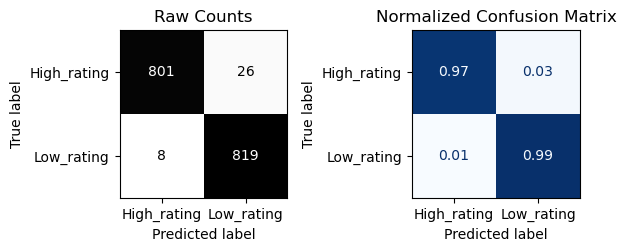


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

 High_rating       0.88      0.87      0.87       179
  Low_rating       0.87      0.88      0.88       184

    accuracy                           0.87       363
   macro avg       0.87      0.87      0.87       363
weighted avg       0.87      0.87      0.87       363



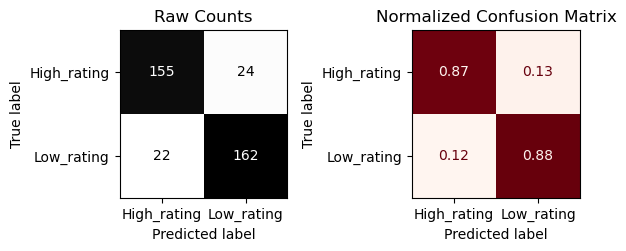

In [22]:
# Evaluate count_pipe
fn.evaluate_classification(count_pipe, X_train, y_train, X_test, y_test)

In [23]:
# Instantiate TF-IDF Vectorizor
tfidf = fn.TfidfVectorizer()

## Instantiate model
tfidfbayes = fn.MultinomialNB()


## Create pipeline: tfidf_pipe
tfidf_pipe = fn.Pipeline([('vectorizer', tfidf),
                       ('bayes', tfidfbayes)])



## Fit pipeline
tfidf_pipe.fit(X_train, y_train)
                      

Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('bayes', MultinomialNB())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

 High_rating       0.98      0.97      0.98       827
  Low_rating       0.97      0.98      0.98       827

    accuracy                           0.98      1654
   macro avg       0.98      0.98      0.98      1654
weighted avg       0.98      0.98      0.98      1654



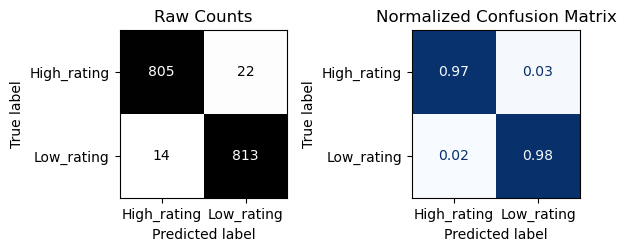


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

 High_rating       0.86      0.90      0.88       179
  Low_rating       0.90      0.86      0.88       184

    accuracy                           0.88       363
   macro avg       0.88      0.88      0.88       363
weighted avg       0.88      0.88      0.88       363



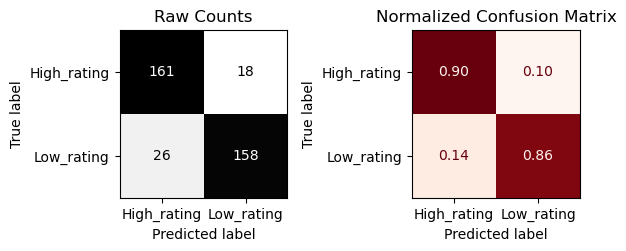

In [24]:
# Evaluate the tfidf_pipeline model
fn.evaluate_classification(tfidf_pipe, X_train, y_train, X_test, y_test)

## `Build a Machine Learning Model`
- Build a sklearn modeling pipeline with a text vectorizer and a classification model.
    - Suggested Models: MultinomialNB, LogisticRegression (you may need to increase max_iter), RandomForestClassifier
- Fit and evaluate the model using the machine learning classification models from sklearn.
    - In a Markdown cell, document your observations from your results. (e.g., how good is the model overall? Is it particularly good/bad at predicting one class?)

In [26]:
from sklearn.ensemble import RandomForestClassifier
rf_pipe  = fn.Pipeline([('vectorizer',fn.CountVectorizer()),
                    ('clf',fn.RandomForestClassifier(class_weight='balanced'))])
rf_pipe.get_params()

{'memory': None,
 'steps': [('vectorizer', CountVectorizer()),
  ('clf', RandomForestClassifier(class_weight='balanced'))],
 'verbose': False,
 'vectorizer': CountVectorizer(),
 'clf': RandomForestClassifier(class_weight='balanced'),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.int64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__preprocessor': None,
 'vectorizer__stop_words': None,
 'vectorizer__strip_accents': None,
 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vectorizer__tokenizer': None,
 'vectorizer__vocabulary': None,
 'clf__bootstrap': True,
 'clf__ccp_alpha': 0.0,
 'clf__class_weight': 'balanced',
 'clf__criterion': 'gini',
 'clf__max_depth': None,
 'clf__max_features': 'sqrt',
 'clf__max_leaf_node

In [33]:
# Define params to try for both vectorizers
param_grid_shared = {
    "vectorizer__max_df": [0.7, 0.8, 0.9],
    'vectorizer__min_df': [ 2, 3, 4 ], 
    "vectorizer__max_features": [None, 1000, 2000],
    "vectorizer__stop_words": [None,'english']
}

# Setting params for the count vectorizer
param_grid_count = {
    'vectorizer':[fn.CountVectorizer()],
    **param_grid_shared
}


# Setting params for tfidf vectorizer 
param_grid_tfidf = {
    'vectorizer': [fn.TfidfVectorizer()],
    "vectorizer__norm": ["l1", "l2"],
    "vectorizer__use_idf": [True, False],
    **param_grid_shared
}

# combine into list of params
params_combined = [param_grid_count, param_grid_tfidf]
params_combined

[{'vectorizer': [CountVectorizer()],
  'vectorizer__max_df': [0.7, 0.8, 0.9],
  'vectorizer__min_df': [2, 3, 4],
  'vectorizer__max_features': [None, 1000, 2000],
  'vectorizer__stop_words': [None, 'english']},
 {'vectorizer': [TfidfVectorizer()],
  'vectorizer__norm': ['l1', 'l2'],
  'vectorizer__use_idf': [True, False],
  'vectorizer__max_df': [0.7, 0.8, 0.9],
  'vectorizer__min_df': [2, 3, 4],
  'vectorizer__max_features': [None, 1000, 2000],
  'vectorizer__stop_words': [None, 'english']}]

In [34]:
%%time
# Create grid search
grid_search = fn.GridSearchCV(rf_pipe, params_combined, cv=3, verbose=1, n_jobs=-1)
    
    
# Fit the model
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 270 candidates, totalling 810 fits
CPU times: total: 10.4 s
Wall time: 6min 4s


{'vectorizer': CountVectorizer(max_df=0.8, max_features=2000, min_df=2, stop_words='english'),
 'vectorizer__max_df': 0.8,
 'vectorizer__max_features': 2000,
 'vectorizer__min_df': 2,
 'vectorizer__stop_words': 'english'}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

 High_rating       1.00      1.00      1.00       827
  Low_rating       1.00      1.00      1.00       827

    accuracy                           1.00      1654
   macro avg       1.00      1.00      1.00      1654
weighted avg       1.00      1.00      1.00      1654



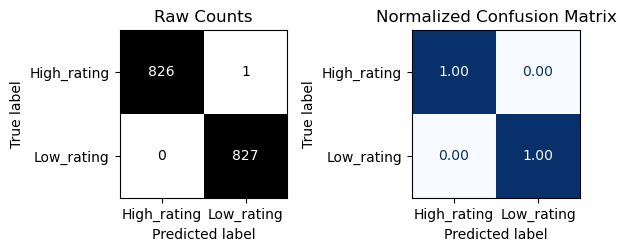


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

 High_rating       0.80      0.90      0.85       179
  Low_rating       0.89      0.78      0.83       184

    accuracy                           0.84       363
   macro avg       0.84      0.84      0.84       363
weighted avg       0.85      0.84      0.84       363



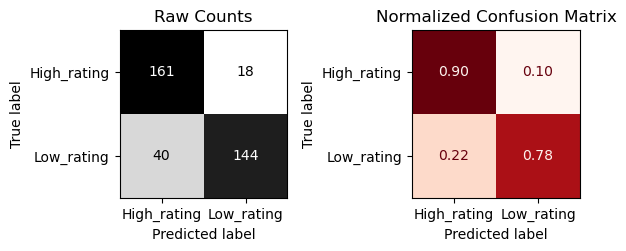

In [35]:
best_rf_pipe = grid_search.best_estimator_
fn.evaluate_classification(best_rf_pipe, X_train, y_train, X_test, y_test)

## `GridSearch Text Vectorization`
- Attempt to improve your model by tuning the text preprocessing steps.

### `Construct a grid of parameters for the text vectorization step. Consider trying:`
- CountVectorizer/TfidfVectorizer
- Stop Words
- ngram_range
- Min_df/max_df

In [37]:
gs_pipe = fn.Pipeline([('vectorizer',fn.CountVectorizer()),
                    ('clf',fn.MultinomialNB())])
gs_pipe.get_params()

{'memory': None,
 'steps': [('vectorizer', CountVectorizer()), ('clf', MultinomialNB())],
 'verbose': False,
 'vectorizer': CountVectorizer(),
 'clf': MultinomialNB(),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.int64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__preprocessor': None,
 'vectorizer__stop_words': None,
 'vectorizer__strip_accents': None,
 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vectorizer__tokenizer': None,
 'vectorizer__vocabulary': None,
 'clf__alpha': 1.0,
 'clf__class_prior': None,
 'clf__fit_prior': True,
 'clf__force_alpha': 'warn'}

In [39]:
# Define params to try for both vectorizers
param_grid_shared = {
    "vectorizer__max_df": [0.7, 0.8, 0.9],
    'vectorizer__min_df': [ 2, 3, 4 ], 
    "vectorizer__max_features": [None, 1000, 2000],
    "vectorizer__stop_words": [None,'english']
}

# Setting params for the count vectorizer
param_grid_count = {
    'vectorizer':[fn.CountVectorizer()],
    **param_grid_shared
}


# Setting params for tfidf vectorizer 
param_grid_tfidf = {
    'vectorizer': [fn.TfidfVectorizer()],
    "vectorizer__norm": ["l1", "l2"],
    "vectorizer__use_idf": [True, False],
    **param_grid_shared
}

# combine into list of params
params_combined = [param_grid_count, param_grid_tfidf]
params_combined

[{'vectorizer': [CountVectorizer()],
  'vectorizer__max_df': [0.7, 0.8, 0.9],
  'vectorizer__min_df': [2, 3, 4],
  'vectorizer__max_features': [None, 1000, 2000],
  'vectorizer__stop_words': [None, 'english']},
 {'vectorizer': [TfidfVectorizer()],
  'vectorizer__norm': ['l1', 'l2'],
  'vectorizer__use_idf': [True, False],
  'vectorizer__max_df': [0.7, 0.8, 0.9],
  'vectorizer__min_df': [2, 3, 4],
  'vectorizer__max_features': [None, 1000, 2000],
  'vectorizer__stop_words': [None, 'english']}]

### `Fit and evaluate the grid search results:`

In [40]:
%%time
# Create grid search
grid_search = fn.GridSearchCV(gs_pipe, params_combined, cv=3, verbose=1, n_jobs=-1)
    
    
# Fit the model
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 270 candidates, totalling 810 fits
CPU times: total: 8.39 s
Wall time: 1min 21s


{'vectorizer': CountVectorizer(max_df=0.8, min_df=3),
 'vectorizer__max_df': 0.8,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 3,
 'vectorizer__stop_words': None}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

 High_rating       0.98      0.94      0.96       827
  Low_rating       0.94      0.98      0.96       827

    accuracy                           0.96      1654
   macro avg       0.96      0.96      0.96      1654
weighted avg       0.96      0.96      0.96      1654



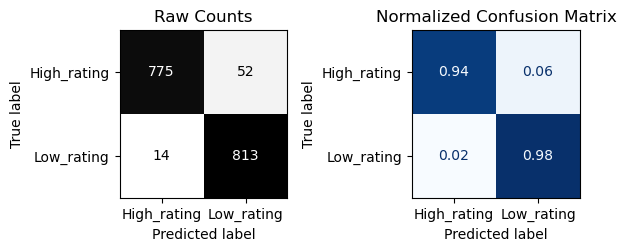


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

 High_rating       0.88      0.85      0.87       179
  Low_rating       0.86      0.89      0.88       184

    accuracy                           0.87       363
   macro avg       0.87      0.87      0.87       363
weighted avg       0.87      0.87      0.87       363



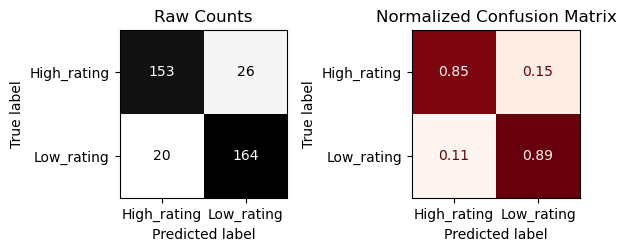

In [41]:
# Evaluate the best estimator
best_gs_pipe = grid_search.best_estimator_
fn.evaluate_classification(best_gs_pipe, X_train, y_train, X_test, y_test)

# <u>Deep NLP (RNNs):
- For this part of the project, you will use the a Keras TextVectorization layer as part of your RNN model.
- This serves the same purpose as using sklearn pipeline:
    - `It bundles text preparation into the model, making it deployment-ready.

In [44]:
df.head()

,original_title,review,rating,ratings,tokens,lemmatized,tokens-joined,lemmas-joined
movie_id,,,,,,,,
7443,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0,High_rating,"[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]","[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]",guilty pleasure personally love great escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation,guilty pleasure personally love great escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation
955,Mission: Impossible II,"The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully underdeveloped).\r\n\r\nEven setting it in predom...",3.0,Low_rating,"[underwhelme, straight, bore, course, see, hunt, climb, mountain, harness, impressive, sure, like, idea, villain, piece, angle, woefully, underdeveloped, set, predominantly, australia, grab, attention, say, cause, pretty, biased, come, hear, tell, mission, impossible, ii, low, point, series, enc...","[underwhelme, straight, bore, course, see, hunt, climb, mountain, harness, impressive, sure, like, idea, villain, piece, angle, woefully, underdeveloped, set, predominantly, australia, grab, attention, say, cause, pretty, biased, come, hear, tell, mission, impossible, ii, low, point, series, enc...",underwhelme straight bore course see hunt climb mountain harness impressive sure like idea villain piece angle woefully underdeveloped set predominantly australia grab attention say cause pretty biased come hear tell mission impossible ii low point series encouraging bad know able rogue nation f...,underwhelme straight bore course see hunt climb mountain harness impressive sure like idea villain piece angle woefully underdeveloped set predominantly australia grab attention say cause pretty biased come hear tell mission impossible ii low point series encouraging bad know able rogue nation f...
955,Mission: Impossible II,After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motion scenes is horrible. You almost might need a barf bag if you can't stand slo-mo every five seconds....,2.0,Low_rating,"[entertainign, mission, impossible, second, installment, turn, terrible, screenwriter, know, fill, 2, hrs, action, overuse, heroic, slow, motion, scene, horrible, need, barf, bag, stand, slo, mo, second, 15, second, amazed, decide, push, m, movie, turn, well, hard, beat, lousy, piece, crap, movie]","[entertainign, mission, impossible, second, installment, turn, terrible, screenwriter, know, fill, 2, hrs, action, overuse, heroic, slow, motion, scene, horrible, need, barf, bag, stand, slo, mo, second, 15, second, amazed, decide, push, m, movie, turn, well, hard, beat, lousy, piece, crap, movie]",entertainign mission impossible second installment turn terrible screenwriter know fill 2 hrs action overuse heroic slow motion scene horrible need barf bag stand slo mo second 15 second amazed decide push m movie turn well hard beat lousy piece crap movie,entertainign mission impossible second installment turn terrible screenwriter know fill 2 hrs action overuse heroic slow motion scene horrible need barf bag stand slo mo second 15 second amazed decide push m movie turn well h

#### Create train/test/val datasets:

In [47]:
# Define X and y
X = df['review']
y_string= df['ratings']
# Instantiate the LabelEncoder
encoder = fn.LabelEncoder()
# Fit and Transform the strings into integers
y = fn.pd.Series(encoder.fit_transform(y_string))
y.value_counts()

1    1224
0    1195
dtype: int64

In [48]:
# Convert to Dataset object
ds = fn.tf.data.Dataset.from_tensor_slices((X, y))
ds

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [49]:
# shuffling the data once
ds = ds.shuffle(buffer_size=len(ds), reshuffle_each_iteration=False)

In [50]:
# Determing how many samples for each split
# Calculate the number of samples for training 
split_train = 0.7
n_train_samples =  int(len(ds) * split_train)
print(f"Use {n_train_samples} samples as training data")
# Calculate the number of samples for validation
split_val = 0.2
n_val_samples = int(len(ds) * split_val)
print(f"Use {n_val_samples} samples as validation data")
# Test size is remainder
split_test = 1 - (split_train + split_val)
print(f"The remaining {len(ds)- (n_train_samples+n_val_samples)} samples will be used as test data.")

Use 1693 samples as training data
Use 483 samples as validation data
The remaining 243 samples will be used as test data.


In [51]:
# Use .take to slice out the number of samples for training
train_ds = ds.take(n_train_samples)
# Skipover the training batches
val_ds = ds.skip(n_train_samples)
# Take .take to slice out the correct number of samples for validation
val_ds = val_ds.take(n_val_samples)
# Skip over all of the training + validation samples, the rest remain as samples for testing
test_ds = ds.skip(n_train_samples + n_val_samples)

In [52]:
# Shuffling just the training data  
train_ds  = train_ds.shuffle(buffer_size = len(train_ds))

In [53]:
#  Setting the batch_size for all datasets
BATCH_SIZE = 1
train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)
# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')

 There are 1693 training batches.
 There are 483 validation batches.
 There are 243 testing batches.


Inspecting the Data

In [54]:
# taking a sample 
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X)
print(example_y)

tf.Tensor([b'We have yet another movie where it is getting high praise for reasons of politics...and possibly because Jamie Lee Curtis is back...but mainly for politics.\r\n\r\nBut it was really nice seeing Jamie Lee Curtis back, and nice in the "it doesn\'t really feel like a Halloween movie without her in it" kind of way.\r\n\r\nUnfortunately that isn\'t enough to save the film, nor is the added over-the-top blood and gore that didn\'t really need a place in the first two movies.\r\n\r\nBut...the blood and gore seemed to replace real scares (though there were a couple) as if to say, yeah, they understand that they aren\'t making this horror movie frightening, so they might as well make it bloodier and hope that it\'s a decent trade off for actual scares.\r\n\r\nThe main issue, however, is that it is spread thin. It\'s like it was written in committee where everyone that there little plot be added to the film despite how difficult that would make actual story telling.\r\n\r\nThe resul

In [55]:
# Get just the text from ds_train
ds_texts = train_ds.map(lambda x, y: x)
# Preview the text
ds_texts.take(1).get_single_element()

<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b"A kid is getting other kids to play poker online. The head of the university doesn't like it and threaten to throw him out. The kid (Justin Timberlake) takes all his money and play some poker, hoping that he will win and his future secure. Well, you guessed it, he loses everything. But, not because he is bad or anything, no, there is this guy called Ivan (Ben Affleck) who runs these online casinos, and who cheats the poor young kids.\r\n\r\nNow there is only one sensible thing to do, which is to go to Costa Rica and confront the bad guy with his scheme. Thats exactly what I would do. Well, nah, not really, but I hope you see where I am going with this. He arrives in Costa Rica, and soon finds himself at the deep end of the pool, hunted by Ivan, some dude named Herrera and the FBI... of course.\r\n\r\nThe plot is idiotic, as you might have guessed. It makes no sense, and the poor actors don't know how to act. And honestly, I don't bl

#### Create a Keras Text Vectorization layer:

In [56]:
# Create the TextVectorization layer
count_vectorizer = fn.tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="count"
)

In [57]:
# Before training, only contains the out of vocab token ([UNK])
count_vectorizer.get_vocabulary()

['[UNK]']

In [58]:
# Fit the layer on the training texts
count_vectorizer.adapt(ds_texts)

In [59]:
# Getting list of vocab
vocab = count_vectorizer.get_vocabulary()
# Exploring list of vocab
type(vocab), len(vocab), vocab[:6]

(list, 24922, ['[UNK]', 'the', 'and', 'a', 'of', 'to'])

In [60]:
# The first value will be the count of all of the words not in the vocobulary
counts= count_vectorizer(['python python python python is the most amazing thing in the world for data science!'])
counts

<tf.Tensor: shape=(1, 24922), dtype=float32, numpy=array([[0., 2., 0., ..., 0., 0., 0.]], dtype=float32)>

#### Build an RNN with the TextVectorization Layer:

In [62]:
# Create Text Vectorization Layer
tfidf_vectorizer = fn.tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="tf_idf",
)
# Build the vectorizer vocabulary
tfidf_vectorizer.adapt(ds_texts)
# Confrim vocabulary size
tfidf_vectorizer.vocabulary_size()

24922

In [63]:
# The first value will be the score of all of the words not in the vocobulary
tfidf= tfidf_vectorizer(['python python python python is the most amazing thing in the world for data science!'])
tfidf

<tf.Tensor: shape=(1, 24922), dtype=float32, numpy=
array([[0.       , 1.4785116, 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)>

Sequence Vectorizer

In [64]:
# Create text Vectorization layer
sequence_vectorizer = fn.tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=30
)
sequence_vectorizer.adapt(ds_texts)
sequence_vectorizer.vocabulary_size()

24923

In [65]:
# Obtain the sequence of sample text with the sequence_vectorizer
sequence= sequence_vectorizer(['python python python python is the most amazing thing in the world for data science!'])
sequence

<tf.Tensor: shape=(1, 30), dtype=int64, numpy=
array([[16469, 16469, 16469, 16469,     7,     2,    74,   392,   148,
            9,     2,   143,    16, 22305,   952,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0]], dtype=int64)>

In [66]:
# Getting list of vocab
vocab = sequence_vectorizer.get_vocabulary()
int_to_str = {idx: word for idx, word in enumerate(vocab)}
int_to_str

{0: '',
 1: '[UNK]',
 2: 'the',
 3: 'and',
 4: 'a',
 5: 'of',
 6: 'to',
 7: 'is',
 8: 'it',
 9: 'in',
 10: 'that',
 11: 'i',
 12: 'this',
 13: 'but',
 14: 'was',
 15: 'with',
 16: 'for',
 17: 'as',
 18: 'movie',
 19: 'film',
 20: 'not',
 21: 'are',
 22: 'its',
 23: 'on',
 24: 'be',
 25: 'you',
 26: 'one',
 27: 'have',
 28: 'his',
 29: 'an',
 30: 'so',
 31: 'all',
 32: 'like',
 33: 'from',
 34: 'he',
 35: 'at',
 36: 'by',
 37: 'just',
 38: 'they',
 39: 'if',
 40: 'about',
 41: 'or',
 42: 'what',
 43: 'more',
 44: 'story',
 45: 'has',
 46: 'there',
 47: 'some',
 48: 'even',
 49: 'who',
 50: 'my',
 51: 'good',
 52: 'really',
 53: 'me',
 54: 'out',
 55: 'very',
 56: 'time',
 57: 'when',
 58: 'no',
 59: 'which',
 60: 'we',
 61: 'only',
 62: 'well',
 63: 'their',
 64: 'had',
 65: 'much',
 66: 'can',
 67: 'up',
 68: 'than',
 69: 'would',
 70: 'also',
 71: 'because',
 72: 'great',
 73: 'way',
 74: 'most',
 75: 'do',
 76: 'into',
 77: 'her',
 78: 'characters',
 79: 'will',
 80: 'were',
 81: 'ho

In [78]:
# What term corresponds to 1000?
int_to_str[1000]

'whats'

- I went one above just to see what would could up, but noticed it can go up to 3k = 'galaxy'